# Introduction to Brevitas - Quantization Aware Training 

Brevitas library allows so called quantization aware training.

That means at the time of training we assume that our model's (network's) destination inference is implemented in lower precision.

We know quantization change inference results.

We can prevent it by appropriate model training, which includes quantization operation "simulation" - our computations are still on floating points.


For this laboratory we will use mentioned brevitas library.

You can install it by running following cell.

In [1]:
%pip install brevitas==0.7.1

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [1]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [2]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

# local_utils file contains util functions for training or display
# CHECK IT
import local_utils as lu

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Datasets

len(train_loader) = 938
len(test_loader) = 157
torch.Size([64, 1, 28, 28])
torch.Size([64])


<Figure size 432x288 with 0 Axes>

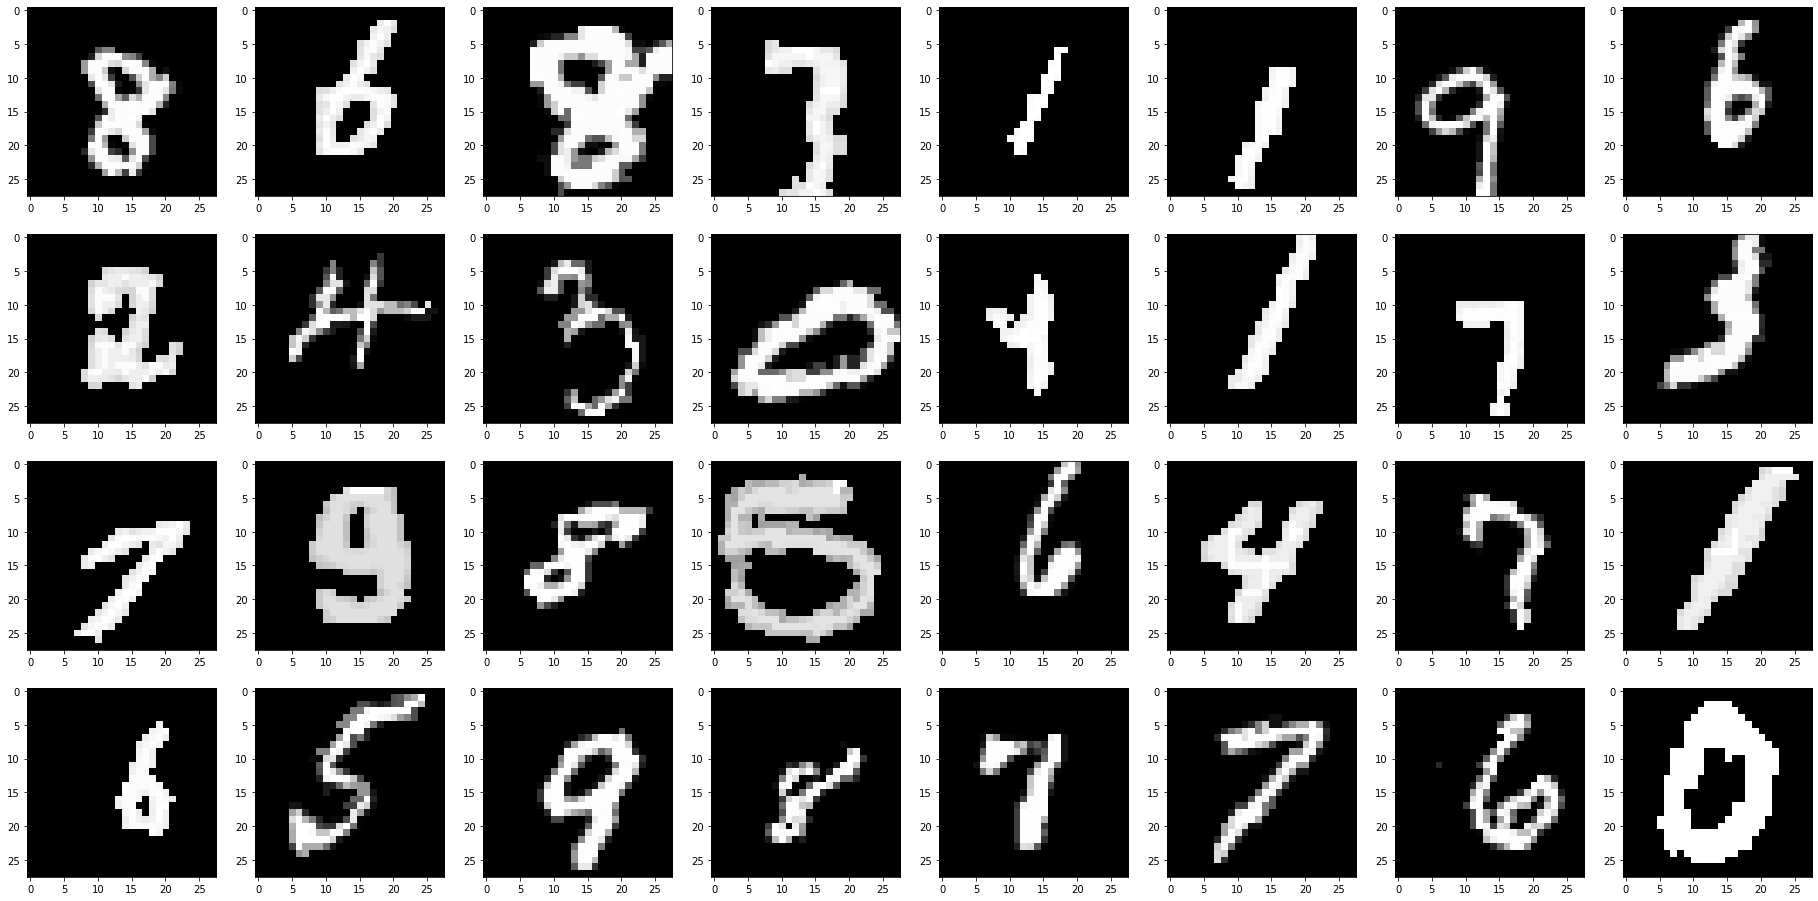

In [3]:
from torchvision.transforms import ToTensor, Compose, RandomAffine, RandomEqualize, RandomRotation

transforms = Compose([
                    RandomAffine(10, (0.1,0.1), (0.8, 1.2)),
                    RandomRotation(5),
                    RandomEqualize(),
                    ToTensor(),
                    ])

BATCH_SIZE = 64

train_dataset = datasets.MNIST('data', 
                              train=True,
                              download=True,
                              transform=transforms)
test_dataset = datasets.MNIST('data', 
                              train=False,
                              download=True,
                              transform=ToTensor())

train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=True)
test_loader = DataLoader(test_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=False)

print("len(train_loader) =", len(train_loader))
print("len(test_loader) =", len(test_loader))

plt.gray()
loader = train_loader
for X, y in loader:
    print(X.shape)
    print(y.shape)
    
    ROWS, COLS = 4, 8
    fig, axs = plt.subplots(ROWS, COLS)
    fig.set_size_inches(COLS*4,ROWS*4)
    axs = np.array(axs).flatten().tolist()
    
    for i, ax in enumerate(axs):
        img = X[i,...]
        class_label = loader.dataset.classes[y[i]]
        ax.imshow(img.permute(1,2,0))
    plt.show()
            
    break
        

1. Brevitas - QuantIdentity

Layer takes arguments:
- quantizer - appropriate object from brvitas library which implements proper quantization method for data type - activation 

    Here is used `Int8ActPerTensorFloatMinMaxInit` - signed fixed point quantization 
- quantizer's arguments: 
    - for used quantizer these are: `min_val` and `max_val`, 
    
    but for quantization is used only maximal absolute value of both.
    
    `bit_width` is also possible to change from default 8 bit. 
    
- `return_quant_tensor` - when to return or not QuantTensor - float tensor with quantization description.

Your task is to explore quantization for all possible fixed point precision for mentioned quantizer.

How many different precisions exist for this quantizer?

Note: brevitas allows for max_val/min_val to different than power of 2, but here use only power of 2.


In [ ]:
from brevitas.nn import QuantIdentity
from brevitas.quant.scaled_int import Int8ActPerTensorFloatMinMaxInit

inp = (torch.rand(1, 1, 4, 5, requires_grad=False) - 0.5) * 20
print("INPUT TENSOR = ",[e*10**4//1 / 10**4 for e in inp.flatten().tolist()])

for i in range(...):
    max_val = ...

    print(f"MAX_VAL = {i+1}")
    print(f"INTEGER BITS = {i+1}")
    identity = QuantIdentity(Int8ActPerTensorFloatMinMaxInit, 
                             min_val=-max_val, 
                             max_val=max_val, 
                            #  bit_width=16,
                             return_quant_tensor=True)
    identity.train(False)

    # Process by quant identity
    t, scale, zp, bw, is_signed, is_from_training_mode = identity(inp)
    
    precision_bits = -torch.log2(scale).round().to(torch.int).item()
    print("Result tensor = ", t.flatten().tolist())
    print("Scale = ", scale.item())
    print("Precision Bits = ", precision_bits)
    print("Bit width = ", bw.to(torch.int).item())


2. QuantConv2d
For quantization of convolution there is needed also weights and bias quantization.

`QuantConv2d` module is a subclass of `torch.nn.Conv2d` and all it's arguments are also available.

Additional arguments:
- `input_quant` - input quantization - it's not necessary to use it, if input is quantized before the layer
- `output_quant` - output quantization - it's not necessary to use it, if output is quantized after the layer,
- `weight_quant` - quantization of convolution weights. Here is used quantizer:

    `Int8WeightPerTensorFloat` - allows for signed fixed point quantization with maximal precision,

- `bias_quant`   - quantization of convolution bias. Here is used quantizer:

    `Int8BiasPerTensorFloatInternalScaling` - allows for signed quantization with scale set internally by 
    
    analysis of weights' quantization,

- `return_quant_tensor` - when to return or not QuantTensor - float tensor with quantization description.

- layer takes also quantizers' parameters with proper prefix f.e. for weight quantizer parameter bit_width is named `weight_bit_widths` 

Your task:

Print weight and bias non-quantized - raw floating point tensors.

Next use methods `quant_weight` and `quant_bias` to obtain their quantized versions. 

For QuantTensors `[input_tq, conv_tq, output_tq]` and quantized tensors of weight and bias: 

print number of theirs' precision bits, bit widths, scale and result tensor, 

Note the number of bits at each level of processing.

In [82]:
from brevitas.nn import QuantConv2d
from brevitas.quant.scaled_int import Int8ActPerTensorFloatMinMaxInit, \
    Int8WeightPerTensorFloat, Int8BiasPerTensorFloatInternalScaling, Int8ActPerTensorFloat


conv_layer = QuantConv2d(1,1,3,padding=1,bias=True, 
                         weight_quant=Int8WeightPerTensorFloat,
                         weight_bit_width=8,
                         bias_quant=Int8BiasPerTensorFloatInternalScaling,
                         return_quant_tensor=True
                         )
input_layer = QuantIdentity(Int8ActPerTensorFloatMinMaxInit, min_val=-1.0, max_val=1.0, return_quant_tensor=True)
output_layer = QuantIdentity(Int8ActPerTensorFloatMinMaxInit, min_val=-4.0, max_val=4.0, return_quant_tensor=True)

input_tensor = torch.rand(1,1,3,3)

input_tq = input_layer(input_tensor)
conv_tq = conv_layer(input_tq)
output_tq = output_layer(conv_tq)

weight_tq = ...
bias_tq = ...

3. Floating point Network quantization allows to obtain so called Quantized Neural Network.

Both networks have the same topology, but QNN has additional nonlinearities - quantization.

Your tasks:

- Create two models of `NeuralNetwork`:
    - floating point model 
    - quantized model

- print parameters names and theirs shapes for both models. 
    
    Are there any differences ?
    

In [92]:
from brevitas.nn import QuantConv2d
from brevitas.quant.scaled_int import Int8ActPerTensorFloatMinMaxInit, \
    Int8WeightPerTensorFloat, Int8BiasPerTensorFloatInternalScaling, Int8ActPerTensorFloat


class NeuralNetwork(nn.Module):
    def __init__(self, 
                 input_shape=(1,28,28), 
                 num_of_classes=10,
                 quantize=True
                 ) -> None:
        super().__init__()
        channels = [input_shape[0],16,32,64,128]
        padding = [1,1,0,0]
        max_pool = [1,1,0,0]
         
        if quantize:
            input_quant = QuantIdentity(Int8ActPerTensorFloat, min_val=-1.0, max_val=1.0)
        else:
            input_quant = QuantIdentity(None)
        
        layers = []
        for i, (ch_in, ch_out, p, mp) in enumerate(zip(channels[:-1],
                                                       channels[1:],
                                                       padding,
                                                       max_pool)):
            conv = QuantConv2d(ch_in, ch_out, 3, padding=p, bias=True, 
                               weight_quant=Int8WeightPerTensorFloat if quantize else None,
                               bias_quant=Int8BiasPerTensorFloatInternalScaling if quantize else None,
                               return_quant_tensor=False
                               )
            layers.append(conv)
            
            if quantize:
                out_quant = QuantIdentity(Int8ActPerTensorFloat, min_val=-1.0, max_val=1.0)
            else:
                out_quant = QuantIdentity(None)
            
            layers.append(out_quant)
            relu = nn.ReLU()
            layers.append(relu)
            
            if mp:
                maxpool = nn.MaxPool2d(2,2)
                layers.append(maxpool)
        
        self.CNN = nn.Sequential(input_quant, *tuple(layers))
        
        CNN_out_shape = [
                         channels[-1],
                         input_shape[-2]//2//2 - 3//2*2 - 3//2*2,
                         input_shape[-1]//2//2 - 3//2*2 - 3//2*2
                        ]
        CNN_flatten_len = torch.prod(torch.tensor(CNN_out_shape))
        print(f"CNN out shape = {CNN_out_shape}")
        print(f"CNN numel = {CNN_flatten_len}")
        self.FC = nn.Sequential(
                               nn.Flatten(),
                               nn.Linear(CNN_flatten_len, num_of_classes),
                               nn.Softmax(1),
                               )
    
    def forward(self, x: torch.Tensor):
        return self.FC(self.CNN(x))
        
        
net = ...
qnet = ...

4. Train floating model:
- for 8 epochs, 
- `SGD` optimizer,
- learning rate = 0.01,
- momentum = 0.6,
- weight_decay = 1e-6 - penalty for weights values
- update period of 5 batches
- cross entropy loss
- accuracy metric


Hint. `local_utils`

5. Display history and print validation/test loss and accuracy for last epoch. 

6. Extract state dict from trained floating point model.

Load it into quantized model (`load_state_dict` method). 

7. Calculate validation loss and metric for quantized model. 

8. Train quantized model with the same parameters as floating point model.


9. Display history of training and validation loss and metric.

Compare results with floating point model training. 

10. *Additional - Train quantized model without initialization by trained floating point model.

You can change training hyperparameters.

6. You can leave a feedback, if you want :)

7. Exercises please upload this file (*.ipynb) to UPEL.